In [1]:
import os
import sys
import time

import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, CondensedNearestNeighbour
from scipy.spatial import cKDTree

import torch
import torchvision.transforms as T

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] 
# 解决负号显示问题
plt.rcParams['axes.unicode_minus'] = False 

sys.path.append("/home/zhouquan/MyDoc/Deep_Learning/My_TAOD/dataset")
from dataset_loader import get_loader
sys.path.append("/home/zhouquan/MyDoc/Deep_Learning/My_Filter")
from Feature_Extractor import select_feature_extractor

In [2]:
def plt_tsne2d(X, Y, kept_indices_renn=[], title="t-SNE"):
    # tsne
    tsne = TSNE(random_state=42)
    X_tsne = tsne.fit_transform(X)
    # 归一化
    scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    X_tsne = scaler.fit_transform(X_tsne)
    
    index0 = [i for i in range(len(Y)) if (Y[i] == 0 and i in set(kept_indices_renn))]
    index1 = [i for i in range(len(Y)) if (Y[i] == 1 and i in set(kept_indices_renn))]
    index2 = [i for i in range(len(Y)) if (Y[i] == 2 and i in set(kept_indices_renn))]
    index3 = [i for i in range(len(Y)) if (Y[i] == 3 and i in set(kept_indices_renn))]
    index4 = [i for i in range(len(Y)) if (Y[i] == 4 and i in set(kept_indices_renn))]
    
    # plot
    plt.figure(figsize=(8, 8), dpi=200)
    colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k','yellow','yellowgreen','wheat']
    makers = ['h', '<', 'x', '^', 's']
    
    plt.scatter(X_tsne[:,0][index0], X_tsne[:,1][index0], c=colors[0], cmap='brg', marker=makers[0], label='鼠咬', s=1)
    plt.scatter(X_tsne[:,0][index1], X_tsne[:,1][index1], c=colors[1], cmap='brg', marker=makers[1], label='开路', s=1)
    plt.scatter(X_tsne[:,0][index2], X_tsne[:,1][index2], c=colors[2], cmap='brg', marker=makers[2], label='短路', s=1)
    plt.scatter(X_tsne[:,0][index3], X_tsne[:,1][index3], c=colors[3], cmap='brg', marker=makers[3], label='毛刺', s=1)
    plt.scatter(X_tsne[:,0][index4], X_tsne[:,1][index4], c=colors[4], cmap='brg', marker=makers[4], label='残铜', s=1)
                
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
FE = select_feature_extractor('vgg19')
FE.eval()

trans = T.Compose([T.ToTensor(), T.Resize((224, 224))])
# data_path = "My_TAOD/dataset/filter/CycleGAN/PCB_200[10-shot]<-DeepPCB_Crop[200-shot]/1500.csv"
# data_path = "My_TAOD/dataset/filter/CycleGAN/PCB_200[10-shot]<-PCB_Crop[200-shot]/1500.csv"
data_path = "My_TAOD/dataset/filter/ConGAN/PCB_200[10-shot]/1500.csv"
data_loader = get_loader(data_path, 256, 4, shuffle=False, trans=trans, dataset_class="PCB_200", require_path=True)

device = "cuda:1"

FE.to(device)

start_time = time.time()

for batch_idx, (X, y, _) in enumerate(data_loader):
    
    X = X.to(device)
    batch_X_data = FE(X)
    batch_X_data = batch_X_data.detach().cpu()
    batch_y = y
    
    if batch_idx == 0:
        data_X = batch_X_data
        data_y = batch_y
    else:
        data_X = torch.cat((data_X, batch_X_data), dim=0)
        data_y = torch.cat((data_y, batch_y), dim=0)

cost_time = time.time() - start_time

data_X = data_X.numpy()
data_y = data_y.numpy()
data_origin_X = data_X
data_origin_y = data_y

original_indices = np.arange(len(data_origin_X))

print(f"特征提取: 样本数：{len(original_indices)} 耗时:{cost_time:.3f}")
print(f"\
类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 1 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 2 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 3 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 4 的样本数: {np.count_nonzero(data_y == 0)}\n\
    ")

特征提取: 样本数：7550 耗时:23.300
类别为 0 的样本数: 1510
类别为 1 的样本数: 1510
类别为 2 的样本数: 1510
类别为 3 的样本数: 1510
类别为 4 的样本数: 1510
    


In [4]:
# RENN = RepeatedEditedNearestNeighbours(sampling_strategy='all', n_neighbors=35) # n_neighbors

# start_time = time.time()
# data_X, data_y = RENN.fit_resample(data_X, data_y)
# cost_time1 = time.time() - start_time

# kept_indices_renn = np.array([np.where((data_origin_X == x).all(axis=1))[0][0] for x in data_X])

# print(f"经过 RENN 后: 样本数：{len(kept_indices_renn)} 耗时:{cost_time1:.3f}")
# print(f"\
# 类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
# 类别为 1 的样本数: {np.count_nonzero(data_y == 1)}\n\
# 类别为 2 的样本数: {np.count_nonzero(data_y == 2)}\n\
# 类别为 3 的样本数: {np.count_nonzero(data_y == 3)}\n\
# 类别为 4 的样本数: {np.count_nonzero(data_y == 4)}\n\
#     ")

In [5]:
# IHT = InstanceHardnessThreshold(sampling_strategy='all', estimator=LogisticRegression(), cv=10, random_state=42) # cv

# start_time = time.time()
# data_X, data_y = IHT.fit_resample(data_X, data_y)
# cost_time2 = time.time() - start_time

# kept_indices_renn_iht = np.array([np.where((data_origin_X == x).all(axis=1))[0][0] for x in data_X])

# print(f"经过 RENN + IHT 后: 样本数：{len(kept_indices_renn_iht)} 耗时:{cost_time2:.3f}")
# print(f"\
# 类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
# 类别为 1 的样本数: {np.count_nonzero(data_y == 1)}\n\
# 类别为 2 的样本数: {np.count_nonzero(data_y == 2)}\n\
# 类别为 3 的样本数: {np.count_nonzero(data_y == 3)}\n\
# 类别为 4 的样本数: {np.count_nonzero(data_y == 4)}\n\
#     ")

In [6]:
def remove_redundant_samples(X, y, k=5, r=None, method='radius'): # r
    """
    基于 k 近邻或 r 邻域的增强样本去重方法。
    
    参数：
    X - 样本特征矩阵 (numpy array, shape: [n_samples, n_features])
    y - 样本标签 (numpy array, shape: [n_samples])
    k - 近邻数量 (默认 5)
    r - 邻域半径 (默认 None，仅在 method='radius' 时有效)
    method - 'knn' 使用 k 近邻, 'radius' 使用 r 邻域
    
    返回：
    过滤后的 X 和 y
    """
    tree = cKDTree(X)
    kill_indices = set()
    
    for i in range(len(X)):
        if i in kill_indices:
            continue
        
        if method == 'knn':
            _, neighbors = tree.query(X[i], k=k + 1)
            neighbors = neighbors[1:]  # 排除自身
        elif method == 'radius':
            neighbors = tree.query_ball_point(X[i], r)
            neighbors.remove(i)
            neighbors = [neighbor for neighbor in neighbors if y[neighbor] == y[i]]
            
        if len(neighbors) > 0:
            kill_indices.update(neighbors)
        
    return np.delete(X, list(kill_indices), axis=0), np.delete(y, list(kill_indices))

start_time = time.time()
data_X, data_y = remove_redundant_samples(data_X, data_y, r=0.2, method='radius')
cost_time3 = time.time() - start_time

kept_indices_renn_iht_rnn = np.array([np.where((data_origin_X == x).all(axis=1))[0][0] for x in data_X])

print(f"经过 RENN + IHT + RNN 后: 样本数：{len(kept_indices_renn_iht_rnn)} 耗时:{cost_time3:.3f}")
print(f"{(cost_time+cost_time1 + cost_time2 + cost_time3):.3f}s")
print(f"\
类别为 0 的样本数: {np.count_nonzero(data_y == 0)}\n\
类别为 1 的样本数: {np.count_nonzero(data_y == 1)}\n\
类别为 2 的样本数: {np.count_nonzero(data_y == 2)}\n\
类别为 3 的样本数: {np.count_nonzero(data_y == 3)}\n\
类别为 4 的样本数: {np.count_nonzero(data_y == 4)}\n\
    ")

经过 RENN + IHT + RNN 后: 样本数：7539 耗时:1.903


NameError: name 'cost_time1' is not defined

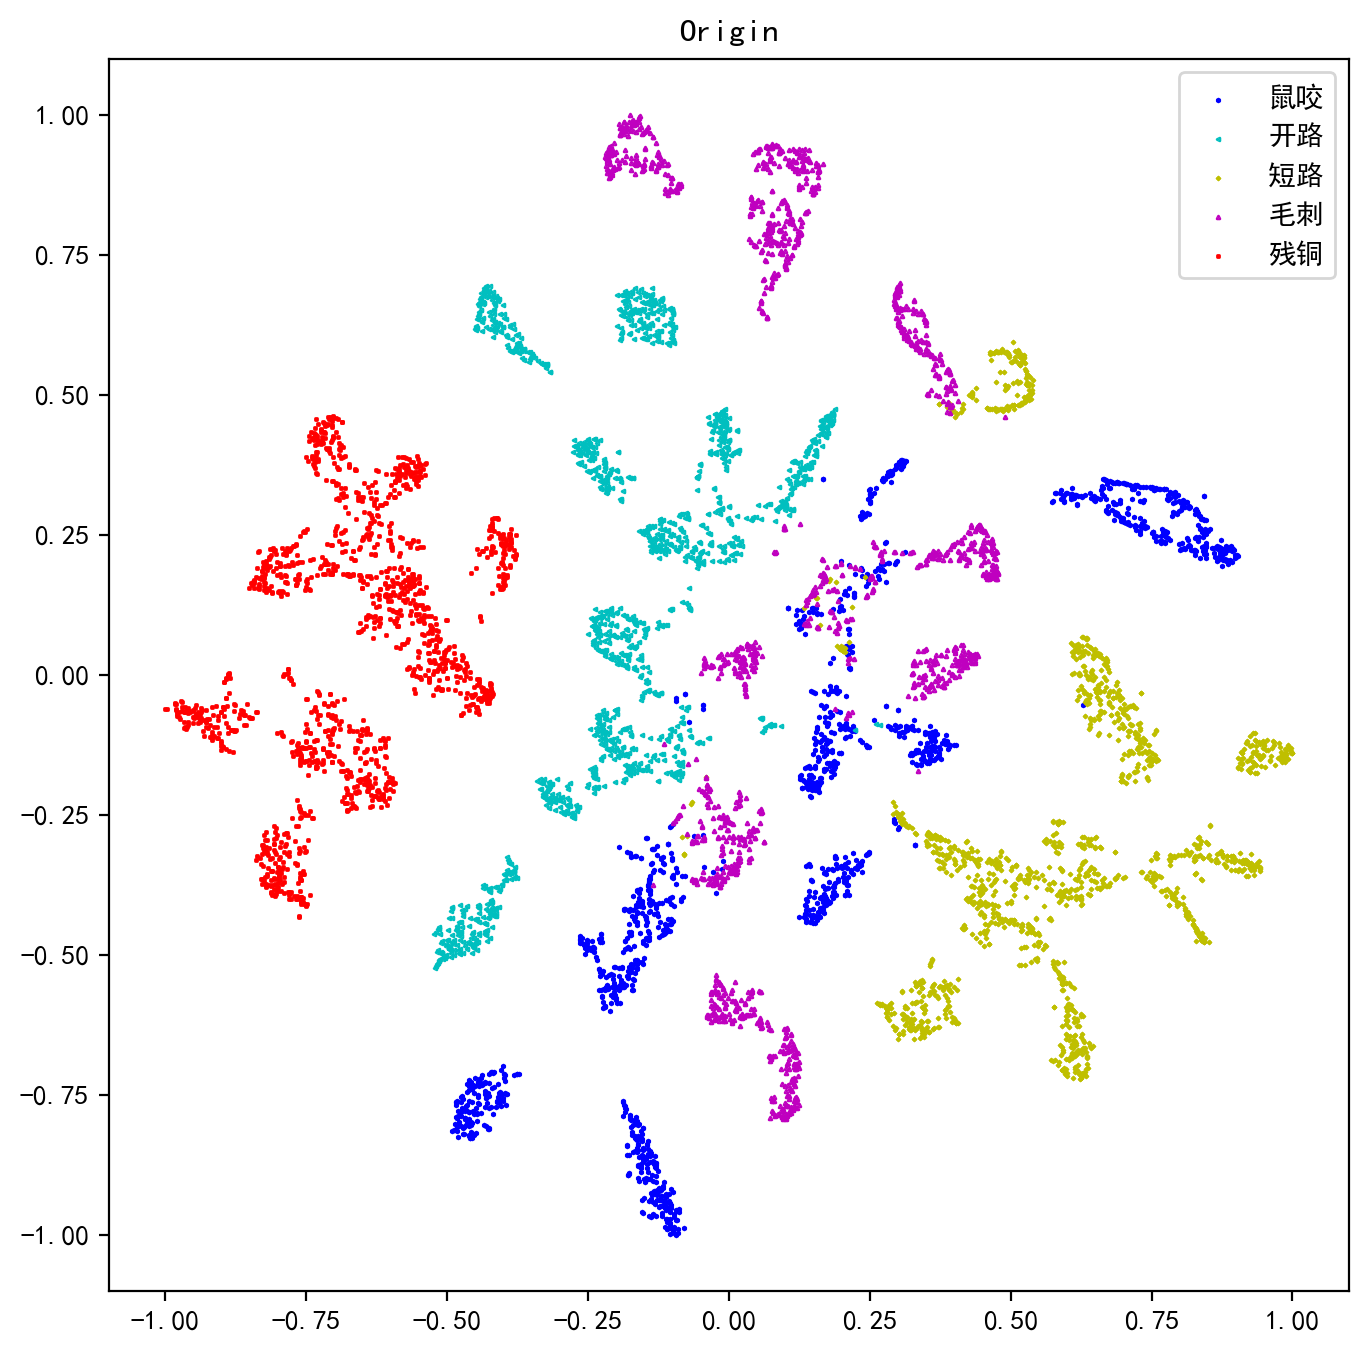

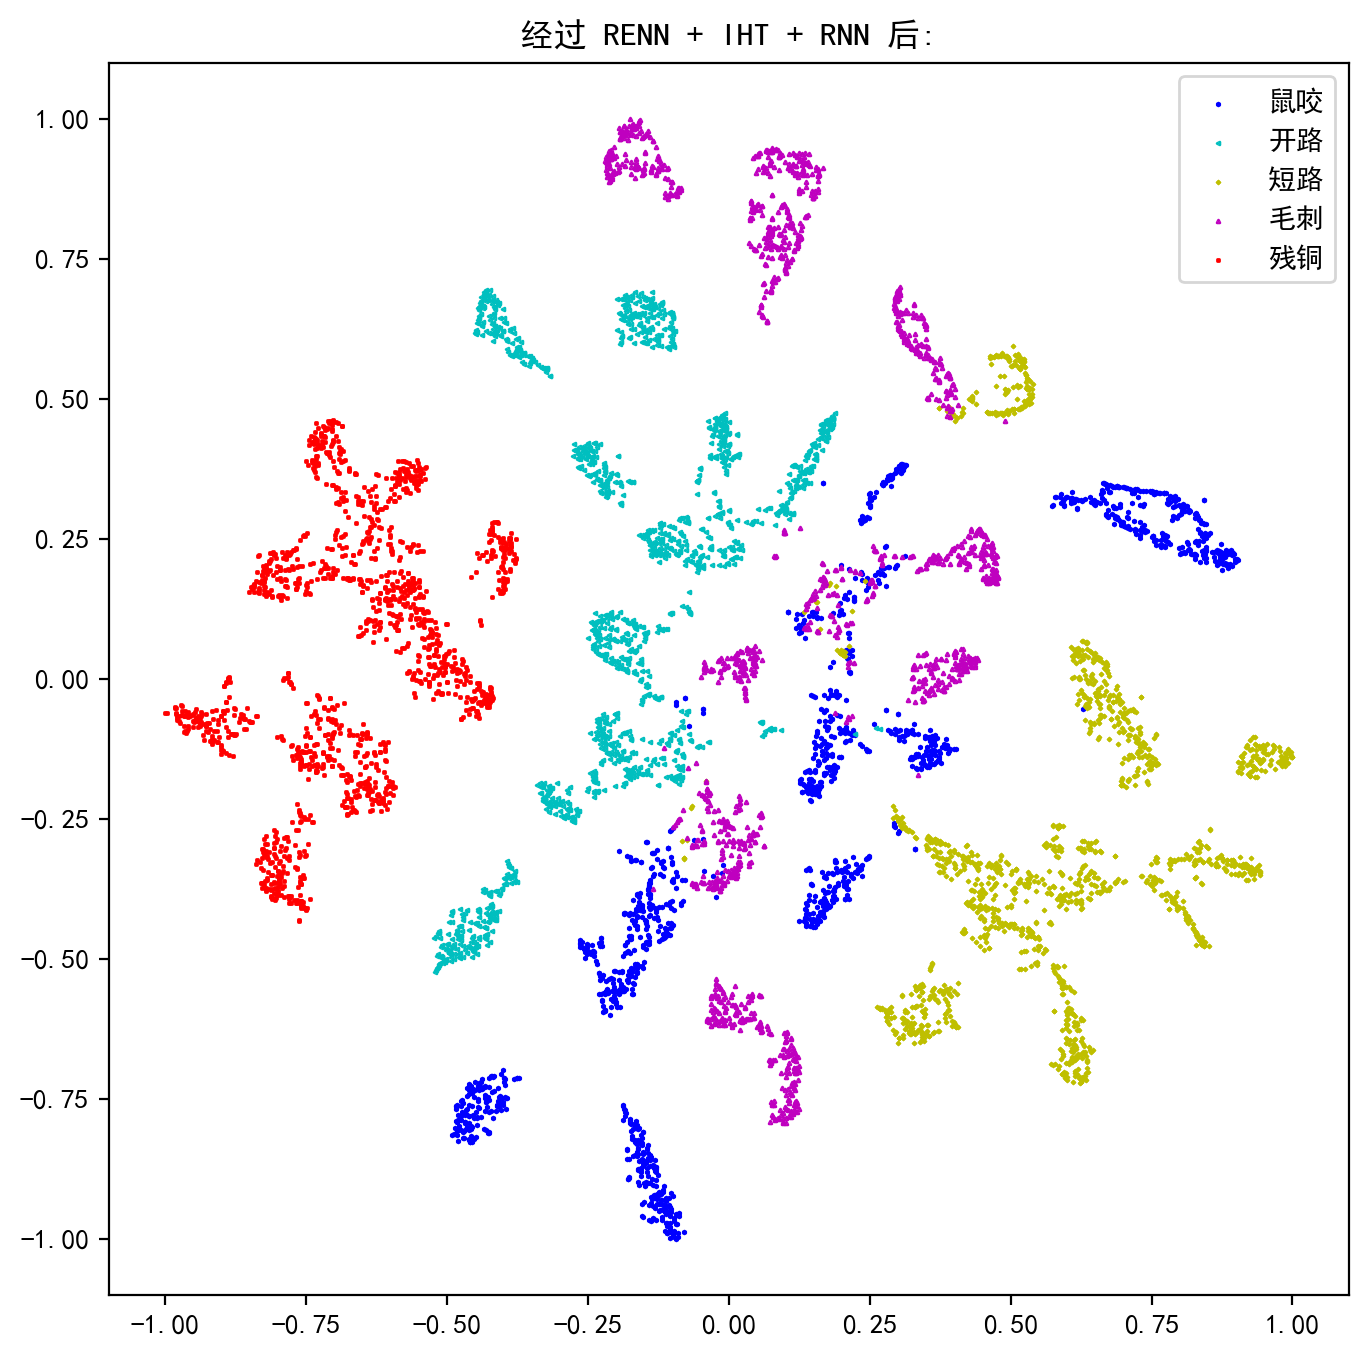

In [ ]:
plt_tsne2d(data_origin_X, data_origin_y, original_indices, title="Origin")
# plt_tsne2d(data_origin_X, data_origin_y, kept_indices_renn, title=f"经过 RENN 后:")
# plt_tsne2d(data_origin_X, data_origin_y, kept_indices_renn_iht, title=f"经过 RENN + IHT 后:")
plt_tsne2d(data_origin_X, data_origin_y, kept_indices_renn_iht_rnn, title=f"经过 RENN + IHT + RNN 后:")

# df = pd.read_csv(data_path)
# df_1 = df.iloc[kept_indices_renn]
# df_2 = df.iloc[kept_indices_renn_iht]
# df_3 = df.iloc[kept_indices_renn_iht_rnn]
# df_1.to_csv(f"{os.path.dirname(data_path)}/{data_path.split('/')[-1].split('.')[0]}_renn.csv", index=False)
# df_2.to_csv(f"{os.path.dirname(data_path)}/{data_path.split('/')[-1].split('.')[0]}_renn_iht.csv", index=False)
# df_3.to_csv(f"{os.path.dirname(data_path)}/{data_path.split('/')[-1].split('.')[0]}_renn_iht_rnn.csv", index=False)
# print("Done!!!")